In [1]:
import pandas as pd

# Load your dataset
df = pd.read_csv("../data/combined_data.csv")

# Convert km/h to m/s
df["v_follower"] = df["Smooth Speed Follower"] * (1000 / 3600)
df["v_leader"] = df["Smooth Speed Leader"] * (1000 / 3600)
df.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader
0,0,2033.00,55.31,55.130,54.9484,55.1524,27.307067,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.263444,15.320111
1,1,2033.02,55.17,55.255,54.9588,55.1654,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.266333,15.323722
2,2,2033.04,55.03,55.380,54.9626,55.1838,27.323949,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.267389,15.328833
3,3,2033.06,55.04,55.430,54.9658,55.2046,27.319727,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.268278,15.334611
4,4,2033.08,55.05,55.480,54.9726,55.2198,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.270167,15.338833


In [2]:
# Compute relative speed and spacing
df["delta_v"] = df["v_follower"] - df["v_leader"]
df["spacing"] = df["Spacing"]  # Already in meters

# Estimate time step and acceleration
df["dt"] = df["Time"].diff()
df["acc_follower"] = df["v_follower"].diff() / df["dt"]

# Drop the first row (NaN)
df_cleaned = df.dropna(subset=["dt", "acc_follower"])

df_cleaned.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader,delta_v,spacing,dt,acc_follower
1,1,2033.02,55.170,55.255,54.9588,55.1654,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.266333,15.323722,-0.057389,27.315506,0.02,0.144444
2,2,2033.04,55.030,55.380,54.9626,55.1838,27.323949,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.267389,15.328833,-0.061444,27.323949,0.02,0.052778
3,3,2033.06,55.040,55.430,54.9658,55.2046,27.319727,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.268278,15.334611,-0.066333,27.319727,0.02,0.044444
4,4,2033.08,55.050,55.480,54.9726,55.2198,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.270167,15.338833,-0.068667,27.315506,0.02,0.094444
5,5,2033.10,55.005,55.340,54.9808,55.2218,27.324214,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.272444,15.339389,-0.066944,27.324214,0.02,0.113889


In [3]:
# Copy the cleaned DataFrame so we can work safely
df_extended = df_cleaned.copy()

# One-hot encode the 'gap_setting' column
gap_dummies = pd.get_dummies(df_extended['gap_setting'], prefix='gap')

# Combine all selected features
features = pd.concat([
    df_extended[["spacing", "delta_v", "v_follower", "speed_fluctuation"]],
    gap_dummies
], axis=1)

# Keep the same target: follower acceleration
target = df_extended["acc_follower"]

In [6]:
# Print example rows
features.tail()

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong
741167,62.213738,0.088222,26.506778,45,False,False,False,True
741168,62.213759,0.088167,26.507111,45,False,False,False,True
741169,62.213782,0.087778,26.507167,45,False,False,False,True
741170,62.208222,0.089333,26.508556,45,False,False,False,True
741171,62.202662,0.091333,26.509278,45,False,False,False,True


In [7]:
target.tail()

741167    0.050000
741168    0.016667
741169    0.002778
741170    0.069444
741171    0.036111
Name: acc_follower, dtype: float64

In [12]:
import matplotlib.pyplot as plt
# Function to plot relationships between each feature and the target variable (acceleration)
def plot_feature_target_relationships(features, target):
    plt.figure(figsize=(18, 5))

    for i, column in enumerate(features.columns):
        plt.subplot(1, 3, i + 1)
        plt.scatter(features[column], target, alpha=0.4, s=10)
        plt.xlabel(column)
        plt.ylabel("Acceleration (m/s²)")
        plt.title(f"{column} vs Acceleration")
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [14]:
# Call the function
# plot_feature_target_relationships(features, target)

In [15]:
# Function to plot feature-target relationships for a specified index range
def plot_feature_target_range(features, target, start=0, end=100):
    plt.figure(figsize=(18, 5))

    # Slice the data for the specified range
    features_range = features.iloc[start:end]
    target_range = target.iloc[start:end]

    for i, column in enumerate(features_range.columns):
        plt.subplot(1, features.shape[1], i + 1)
        plt.scatter(features_range[column], target_range, alpha=0.6, s=20)
        plt.xlabel(column)
        plt.ylabel("Acceleration (m/s²)")
        plt.title(f"{column} vs Acceleration (Rows {start}–{end})")
        plt.grid(True)

    plt.tight_layout()
    plt.show()

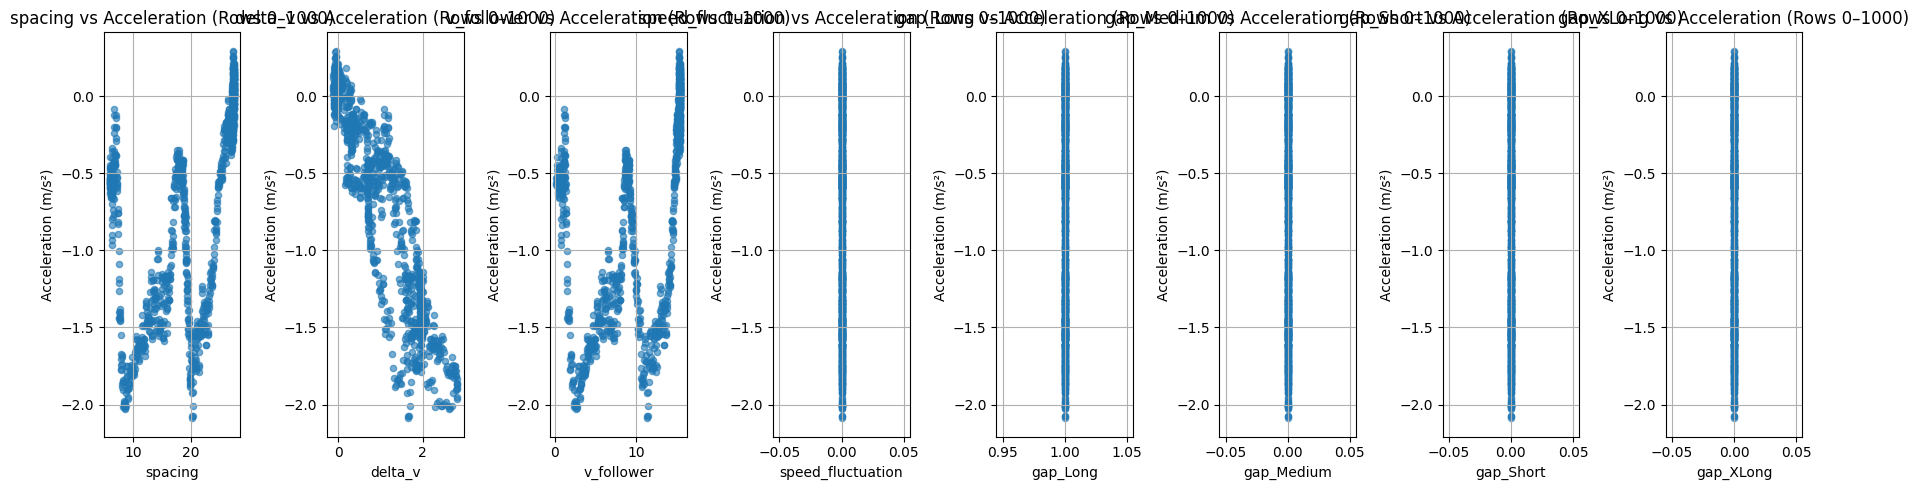

In [16]:
# Example usage: plot only the first 200 data points
plot_feature_target_range(features, target, start=0, end=1000)

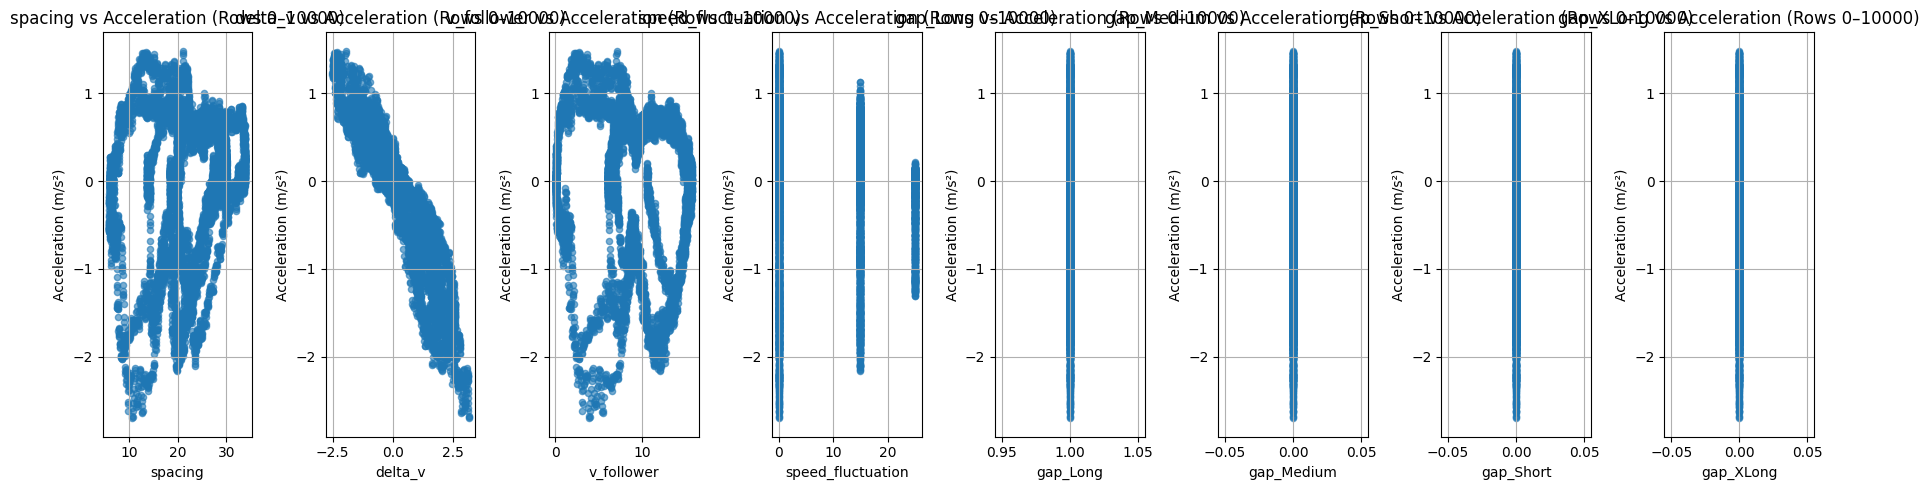

In [17]:
# Example usage: plot only the first 200 data points
plot_feature_target_range(features, target, start=0, end=10000)

## Train Regression Model

In [18]:
# Re-import necessary packages after code execution environment reset
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, random_state=42
)

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [19]:
# Predict and evaluate
y_pred = rf_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

rmse, r2

(0.011715763492320482, 0.9784763479411611)

In [31]:
X_train

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong
177576,30.879050,0.239000,15.676833,35,True,False,False,False
411991,35.363375,-1.258278,16.518500,25,False,False,True,False
297644,39.845947,0.199222,24.466833,35,False,True,False,False
500556,22.924097,0.267111,15.627500,0,False,False,True,False
373598,21.519393,-1.479778,12.478278,25,False,False,True,False
...,...,...,...,...,...,...,...,...
259181,36.873228,0.362944,26.573278,35,False,True,False,False
365844,21.523059,1.220167,15.326500,0,False,False,True,False
131935,34.778595,2.656222,20.848500,35,True,False,False,False
671169,32.503825,3.226667,13.941278,0,False,False,False,True


## Predicted vs Actual Acceleration

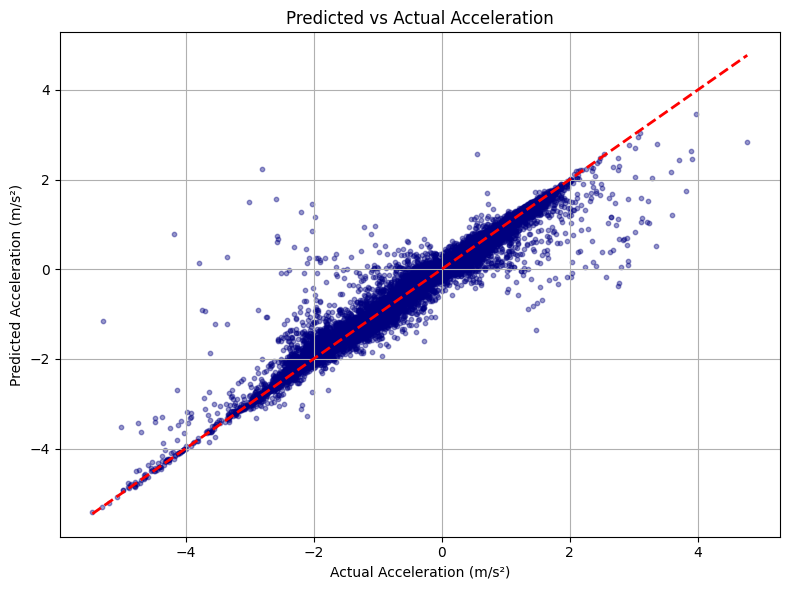

In [39]:
import matplotlib.pyplot as plt
import numpy as np

# --- Plot predicted vs actual acceleration ---
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.4, s=10, color='navy')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)
plt.xlabel("Actual Acceleration (m/s²)")
plt.ylabel("Predicted Acceleration (m/s²)")
plt.title("Predicted vs Actual Acceleration")
plt.grid(True)
plt.tight_layout()
plt.show()

## Feature Importance

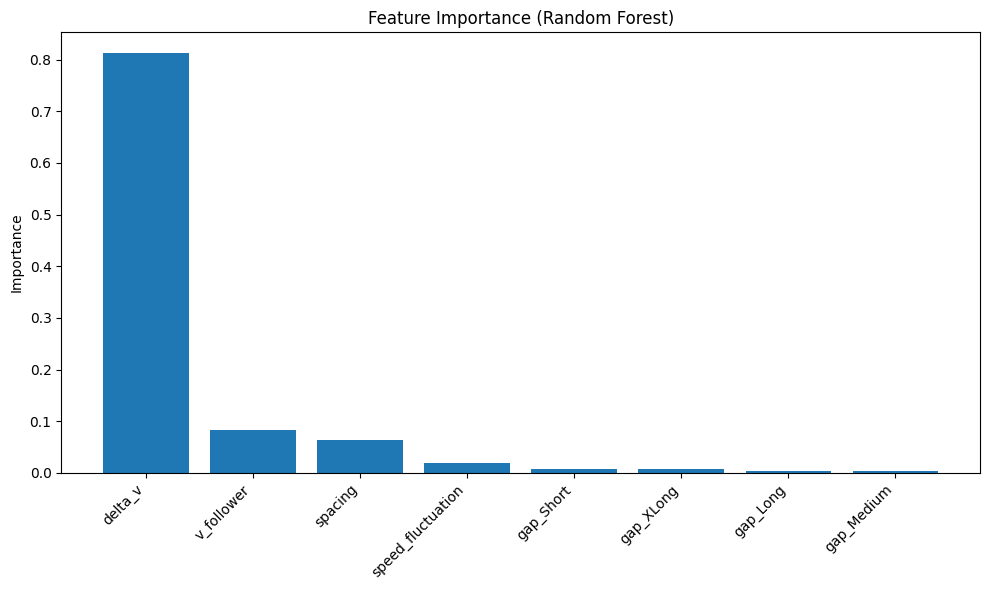

In [40]:
# --- Examine feature importance ---
importances = rf_model.feature_importances_
feature_names = extended_features.columns
sorted_idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), importances[sorted_idx], align='center')
plt.xticks(range(len(importances)), feature_names[sorted_idx], rotation=45, ha='right')
plt.title("Feature Importance (Random Forest)")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

## calculate residuals

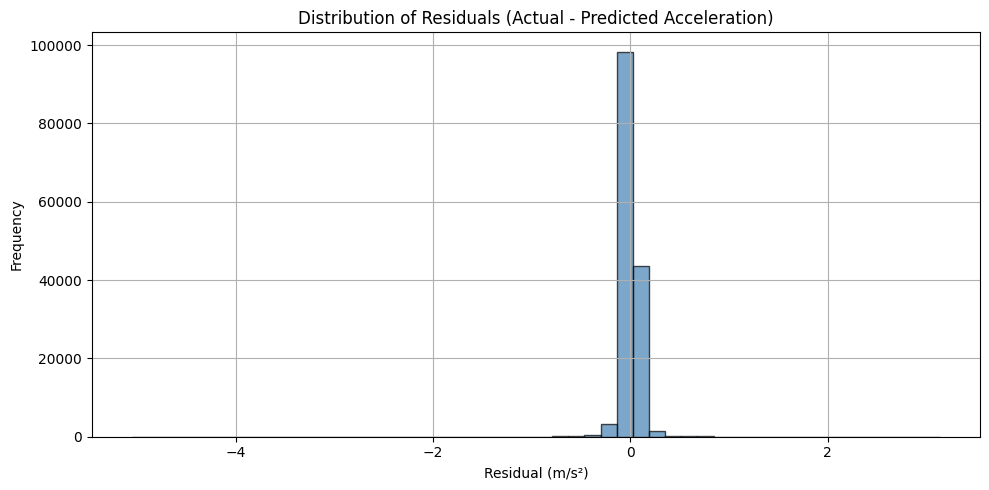

In [41]:
# Calculate residuals (errors)
residuals = y_test - y_pred

# Plot histogram of residuals
plt.figure(figsize=(10, 5))
plt.hist(residuals, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
plt.title("Distribution of Residuals (Actual - Predicted Acceleration)")
plt.xlabel("Residual (m/s²)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()

## Residuals Vs Predicted Acceleration

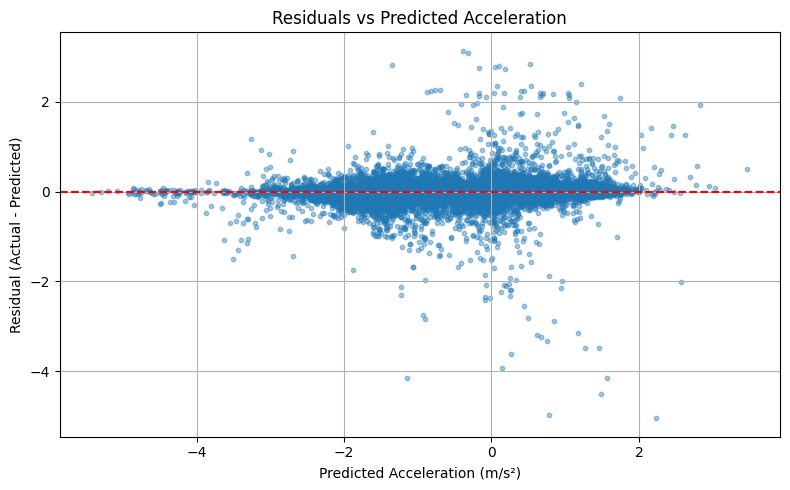

In [42]:
# Plot residuals vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.4, s=10)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted Acceleration")
plt.xlabel("Predicted Acceleration (m/s²)")
plt.ylabel("Residual (Actual - Predicted)")
plt.grid(True)
plt.tight_layout()
plt.show()

## predict on full data

In [47]:
X_test

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong
523794,33.393522,0.304333,24.450833,15,False,False,True,False
515705,31.156693,-1.480333,17.025889,35,False,False,True,False
641830,24.167738,1.153667,9.764778,15,False,False,False,True
95438,32.987086,-0.877889,13.859611,25,True,False,False,False
464438,20.394870,1.069444,11.836611,15,False,False,True,False
...,...,...,...,...,...,...,...,...
5358,27.325592,0.310000,15.433444,15,True,False,False,False
724259,35.205127,2.775944,14.309389,0,False,False,False,True
629448,47.280103,-1.981278,17.868611,35,False,False,False,True
185418,12.435839,-1.893889,2.588111,0,False,True,False,False


In [37]:
reformed_df = features.copy()

In [38]:
reformed_df['acc_follower'] = target
reformed_df

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower
1,27.315506,-0.057389,15.266333,0,True,False,False,False,0.144444
2,27.323949,-0.061444,15.267389,0,True,False,False,False,0.052778
3,27.319727,-0.066333,15.268278,0,True,False,False,False,0.044444
4,27.315506,-0.068667,15.270167,0,True,False,False,False,0.094444
5,27.324214,-0.066944,15.272444,0,True,False,False,False,0.113889
...,...,...,...,...,...,...,...,...,...
741167,62.213738,0.088222,26.506778,45,False,False,False,True,0.050000
741168,62.213759,0.088167,26.507111,45,False,False,False,True,0.016667
741169,62.213782,0.087778,26.507167,45,False,False,False,True,0.002778
741170,62.208222,0.089333,26.508556,45,False,False,False,True,0.069444


In [48]:
# for i,rows in reformed_df.iterrows():
    
#     single_data_point = rows[["spacing", "delta_v", "v_follower", "speed_fluctuation","gap_Long","gap_Medium","gap_Short","gap_XLong"]]
#     print(single_data_point)
#     prediction = rf_model.predict(single_data)
#     print(prediction)
#     if i == 2:
#         break
    

In [49]:
prediction = rf_model.predict(features)

In [50]:
prediction

array([0.11869444, 0.08144444, 0.05866667, ..., 0.01516667, 0.04775   ,
       0.03355556], shape=(741155,))

In [51]:
reformed_df['pred_acc_follower'] = prediction
reformed_df

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower
1,27.315506,-0.057389,15.266333,0,True,False,False,False,0.144444,0.118694
2,27.323949,-0.061444,15.267389,0,True,False,False,False,0.052778,0.081444
3,27.319727,-0.066333,15.268278,0,True,False,False,False,0.044444,0.058667
4,27.315506,-0.068667,15.270167,0,True,False,False,False,0.094444,0.079222
5,27.324214,-0.066944,15.272444,0,True,False,False,False,0.113889,0.103278
...,...,...,...,...,...,...,...,...,...,...
741167,62.213738,0.088222,26.506778,45,False,False,False,True,0.050000,0.036111
741168,62.213759,0.088167,26.507111,45,False,False,False,True,0.016667,0.023250
741169,62.213782,0.087778,26.507167,45,False,False,False,True,0.002778,0.015167
741170,62.208222,0.089333,26.508556,45,False,False,False,True,0.069444,0.047750


In [52]:
reformed_df['dt'] = 0.02
reformed_df

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower,dt
1,27.315506,-0.057389,15.266333,0,True,False,False,False,0.144444,0.118694,0.02
2,27.323949,-0.061444,15.267389,0,True,False,False,False,0.052778,0.081444,0.02
3,27.319727,-0.066333,15.268278,0,True,False,False,False,0.044444,0.058667,0.02
4,27.315506,-0.068667,15.270167,0,True,False,False,False,0.094444,0.079222,0.02
5,27.324214,-0.066944,15.272444,0,True,False,False,False,0.113889,0.103278,0.02
...,...,...,...,...,...,...,...,...,...,...,...
741167,62.213738,0.088222,26.506778,45,False,False,False,True,0.050000,0.036111,0.02
741168,62.213759,0.088167,26.507111,45,False,False,False,True,0.016667,0.023250,0.02
741169,62.213782,0.087778,26.507167,45,False,False,False,True,0.002778,0.015167,0.02
741170,62.208222,0.089333,26.508556,45,False,False,False,True,0.069444,0.047750,0.02


In [55]:
import numpy as np

def plot_acc_comparison_from_dataframe(df, actual_col="acc_follower", pred_col="pred_acc_follower", dt_col="dt", limit=(0, 1000)):
    # Extract the desired range
    start, end = limit
    df_slice = df.iloc[start:end]

    # Compute time axis using cumulative dt
    time = np.cumsum(df_slice[dt_col].values)

    # Extract actual and predicted acceleration
    actual = df_slice[actual_col].values
    predicted = df_slice[pred_col].values

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(time, actual, label="Actual Acceleration", linewidth=1.5)
    plt.plot(time, predicted, label="Predicted Acceleration", linewidth=1.5, linestyle="--")
    plt.xlabel("Time (s)")
    plt.ylabel("Acceleration (m/s²)")
    plt.title(f"Actual vs Predicted Acceleration (Rows {start}–{end})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

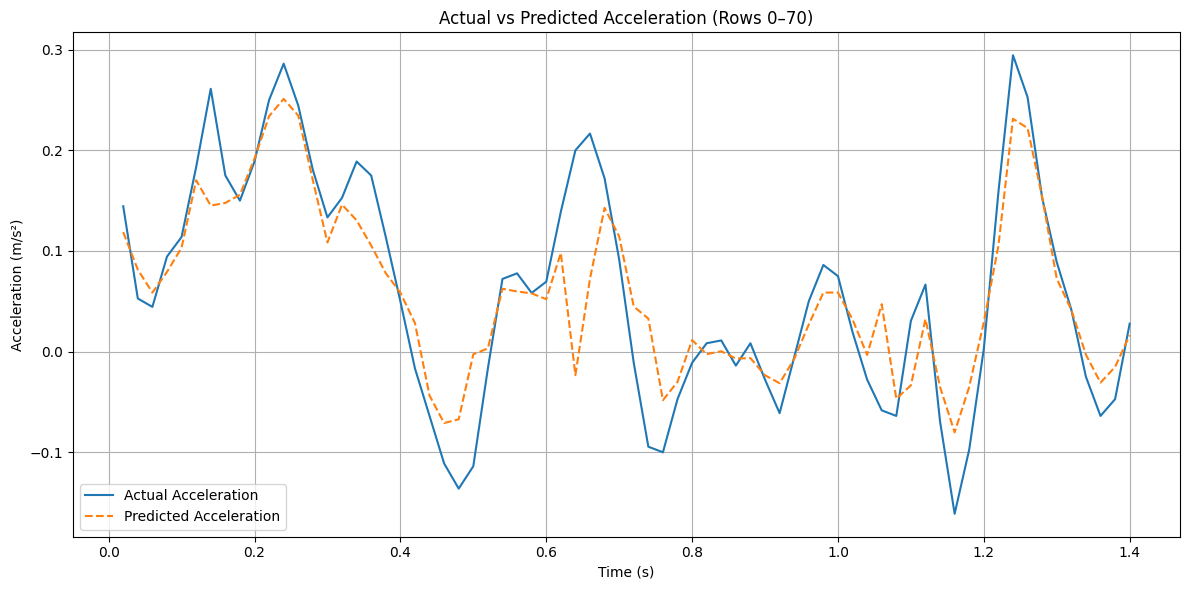

In [58]:
plot_acc_comparison_from_dataframe(reformed_df, limit=(0, 70))

### Residuals Cluster Around 0
Most points are tightly grouped around the red line,suggests  model is accurate and unbiased across most predictions

In [43]:
# Updated function to include a `limit` parameter for flexible range selection
def plot_actual_vs_predicted_acceleration(y_true, y_pred, limit=(0, 1000)):
    import matplotlib.pyplot as plt

    start, end = limit
    y_true_sample = y_true[start:end].reset_index(drop=True)
    y_pred_sample = pd.Series(y_pred[start:end])

    plt.figure(figsize=(12, 6))
    plt.plot(y_true_sample, label='Actual Acceleration', linewidth=1.5)
    plt.plot(y_pred_sample, label='Predicted Acceleration', linewidth=1.5, linestyle='--')
    plt.title(f"Actual vs Predicted Acceleration (Index {start} to {end})")
    plt.xlabel("Time Step (index)")
    plt.ylabel("Acceleration (m/s²)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


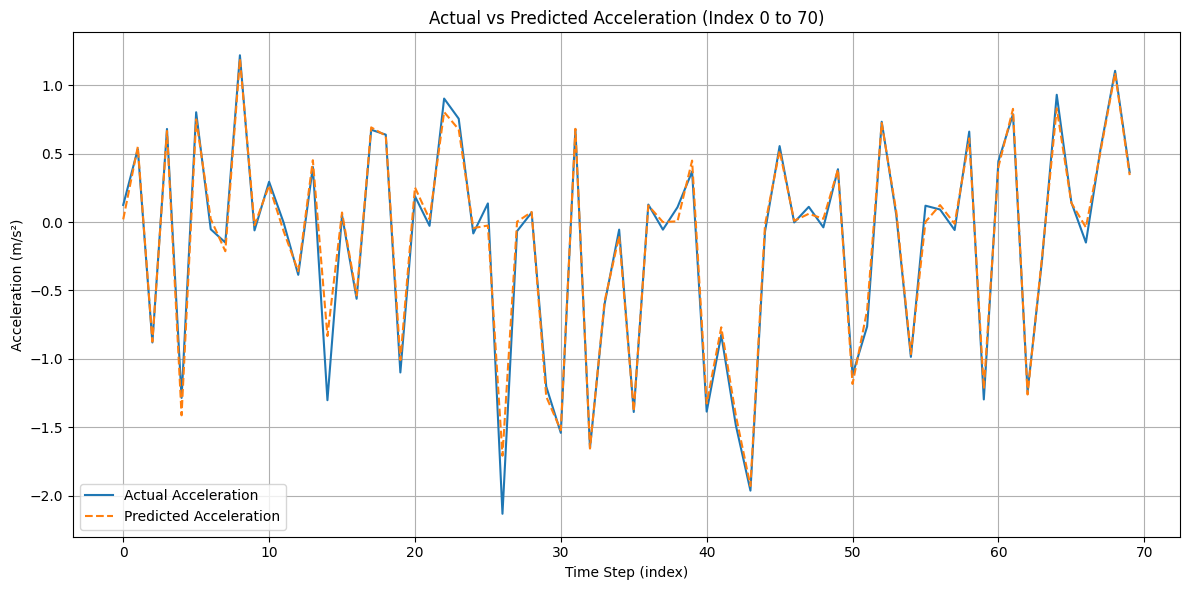

In [45]:
# Example usage with limit range
plot_actual_vs_predicted_acceleration(y_test.reset_index(drop=True), y_pred, limit=(0, 70))

In [46]:
df_cleaned.head()

,Unnamed: 0,Time,Speed Follower,Speed Leader,Smooth Speed Follower,Smooth Speed Leader,Spacing,file_path,gap_setting,desired_speed,free_flow_speed,speed_fluctuation,v_follower,v_leader,delta_v,spacing,dt,acc_follower
1,1,2033.02,55.170,55.255,54.9588,55.1654,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.266333,15.323722,-0.057389,27.315506,0.02,0.144444
2,2,2033.04,55.030,55.380,54.9626,55.1838,27.323949,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.267389,15.328833,-0.061444,27.323949,0.02,0.052778
3,3,2033.06,55.040,55.430,54.9658,55.2046,27.319727,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.268278,15.334611,-0.066333,27.319727,0.02,0.044444
4,4,2033.08,55.050,55.480,54.9726,55.2198,27.315506,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.270167,15.338833,-0.068667,27.315506,0.02,0.094444
5,5,2033.10,55.005,55.340,54.9808,55.2218,27.324214,/content/drive/MyDrive/GRA/Datasets/EV Data/Hy...,Long,0,35,0,15.272444,15.339389,-0.066944,27.324214,0.02,0.113889


## Predicted plot for medium gap

In [48]:
features.head()

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong
1,27.315506,-0.057389,15.266333,0,True,False,False,False
2,27.323949,-0.061444,15.267389,0,True,False,False,False
3,27.319727,-0.066333,15.268278,0,True,False,False,False
4,27.315506,-0.068667,15.270167,0,True,False,False,False
5,27.324214,-0.066944,15.272444,0,True,False,False,False


In [62]:
## Concat feature and target

df_merged = features.copy()
df_merged['acc_follower'] = target.values

In [63]:
df_merged.head()

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower
1,27.315506,-0.057389,15.266333,0,True,False,False,False,0.144444
2,27.323949,-0.061444,15.267389,0,True,False,False,False,0.052778
3,27.319727,-0.066333,15.268278,0,True,False,False,False,0.044444
4,27.315506,-0.068667,15.270167,0,True,False,False,False,0.094444
5,27.324214,-0.066944,15.272444,0,True,False,False,False,0.113889


In [59]:
medium_gap = reformed_df[reformed_df.gap_Medium==True]
medium_gap.shape


(181315, 11)

In [62]:
medium_gap

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower,dt
181868,25.825583,0.349000,15.752333,0,False,True,False,False,0.009968,-0.030776,0.02
181869,25.812552,0.343167,15.749500,0,False,True,False,False,-0.141667,-0.127967,0.02
181870,25.799521,0.341833,15.747222,0,False,True,False,False,-0.113889,-0.120972,0.02
181871,25.782146,0.344500,15.745000,0,False,True,False,False,-0.111111,-0.108623,0.02
181872,25.764771,0.345333,15.743222,0,False,True,False,False,-0.088889,-0.098940,0.02
...,...,...,...,...,...,...,...,...,...,...,...
363181,38.651577,0.065333,26.541056,45,False,True,False,False,-0.119444,-0.116028,0.02
363182,38.657152,0.063056,26.539056,45,False,True,False,False,-0.100000,-0.101083,0.02
363183,38.662727,0.059500,26.537056,45,False,True,False,False,-0.100000,-0.090028,0.02
363184,38.657167,0.055500,26.535444,45,False,True,False,False,-0.080556,-0.081556,0.02


In [63]:
def compute_predicted_speed(df, acc_col="pred_acc_follower", dt_col="dt", 
                            initial_speed_col="v_follower", output_col="pred_speed_follower"):
    """
    Integrate predicted acceleration over time to get predicted speed.
    Assumes fixed or variable dt and initial speed from the first row.
    """
    predicted_speed = [df[initial_speed_col].iloc[0]]  # start with the actual initial speed
    for i in range(1, len(df)):
        dt = df[dt_col].iloc[i]
        acc = df[acc_col].iloc[i - 1]
        v_new = predicted_speed[-1] + acc * dt
        predicted_speed.append(v_new)
    
    df[output_col] = predicted_speed
    return df



In [66]:
medium_gap = compute_predicted_speed(medium_gap)

/tmp/ipykernel_61453/1457290478.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[output_col] = predicted_speed


In [67]:
medium_gap

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower,dt,pred_speed_follower
181868,25.825583,0.349000,15.752333,0,False,True,False,False,0.009968,-0.030776,0.02,15.752333
181869,25.812552,0.343167,15.749500,0,False,True,False,False,-0.141667,-0.127967,0.02,15.751718
181870,25.799521,0.341833,15.747222,0,False,True,False,False,-0.113889,-0.120972,0.02,15.749158
181871,25.782146,0.344500,15.745000,0,False,True,False,False,-0.111111,-0.108623,0.02,15.746739
181872,25.764771,0.345333,15.743222,0,False,True,False,False,-0.088889,-0.098940,0.02,15.744567
...,...,...,...,...,...,...,...,...,...,...,...,...
363181,38.651577,0.065333,26.541056,45,False,True,False,False,-0.119444,-0.116028,0.02,14.076137
363182,38.657152,0.063056,26.539056,45,False,True,False,False,-0.100000,-0.101083,0.02,14.073816
363183,38.662727,0.059500,26.537056,45,False,True,False,False,-0.100000,-0.090028,0.02,14.071795
363184,38.657167,0.055500,26.535444,45,False,True,False,False,-0.080556,-0.081556,0.02,14.069994


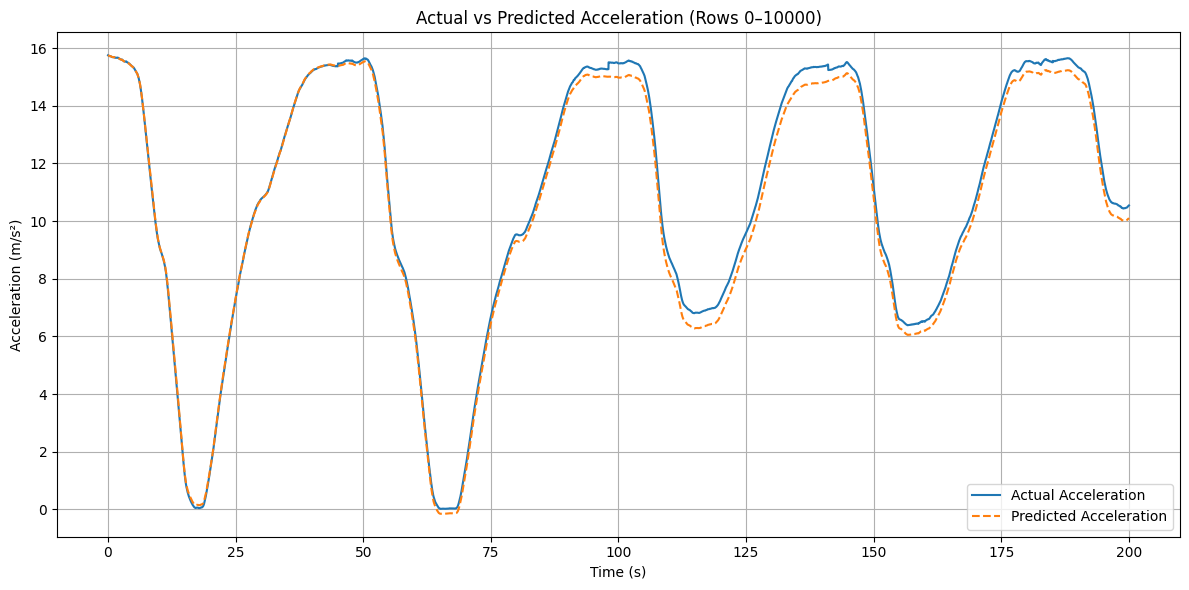

In [70]:
plot_acc_comparison_from_dataframe(medium_gap, actual_col="v_follower", pred_col="pred_speed_follower", dt_col="dt", limit=(0, 10000))

## Predicted plot for long gap

In [71]:
long_gap = reformed_df[reformed_df.gap_Long==True]
long_gap.shape

(181865, 11)

In [72]:
long_gap

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower,dt
1,27.315506,-0.057389,15.266333,0,True,False,False,False,0.144444,0.118694,0.02
2,27.323949,-0.061444,15.267389,0,True,False,False,False,0.052778,0.081444,0.02
3,27.319727,-0.066333,15.268278,0,True,False,False,False,0.044444,0.058667,0.02
4,27.315506,-0.068667,15.270167,0,True,False,False,False,0.094444,0.079222,0.02
5,27.324214,-0.066944,15.272444,0,True,False,False,False,0.113889,0.103278,0.02
...,...,...,...,...,...,...,...,...,...,...,...
181863,47.719633,0.086056,26.626222,45,True,False,False,False,0.050000,0.022611,0.02
181864,47.719565,0.087667,26.626722,45,True,False,False,False,0.025000,0.002194,0.02
181865,47.719497,0.085833,26.625500,45,True,False,False,False,-0.061111,-0.033639,0.02
181866,47.708379,0.084167,26.625389,45,True,False,False,False,-0.005556,0.002000,0.02


In [73]:
long_gap = compute_predicted_speed(long_gap)

/tmp/ipykernel_61453/1457290478.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[output_col] = predicted_speed


In [74]:
long_gap

,spacing,delta_v,v_follower,speed_fluctuation,gap_Long,gap_Medium,gap_Short,gap_XLong,acc_follower,pred_acc_follower,dt,pred_speed_follower
1,27.315506,-0.057389,15.266333,0,True,False,False,False,0.144444,0.118694,0.02,15.266333
2,27.323949,-0.061444,15.267389,0,True,False,False,False,0.052778,0.081444,0.02,15.268707
3,27.319727,-0.066333,15.268278,0,True,False,False,False,0.044444,0.058667,0.02,15.270336
4,27.315506,-0.068667,15.270167,0,True,False,False,False,0.094444,0.079222,0.02,15.271509
5,27.324214,-0.066944,15.272444,0,True,False,False,False,0.113889,0.103278,0.02,15.273094
...,...,...,...,...,...,...,...,...,...,...,...,...
181863,47.719633,0.086056,26.626222,45,True,False,False,False,0.050000,0.022611,0.02,15.345478
181864,47.719565,0.087667,26.626722,45,True,False,False,False,0.025000,0.002194,0.02,15.345931
181865,47.719497,0.085833,26.625500,45,True,False,False,False,-0.061111,-0.033639,0.02,15.345974
181866,47.708379,0.084167,26.625389,45,True,False,False,False,-0.005556,0.002000,0.02,15.345302


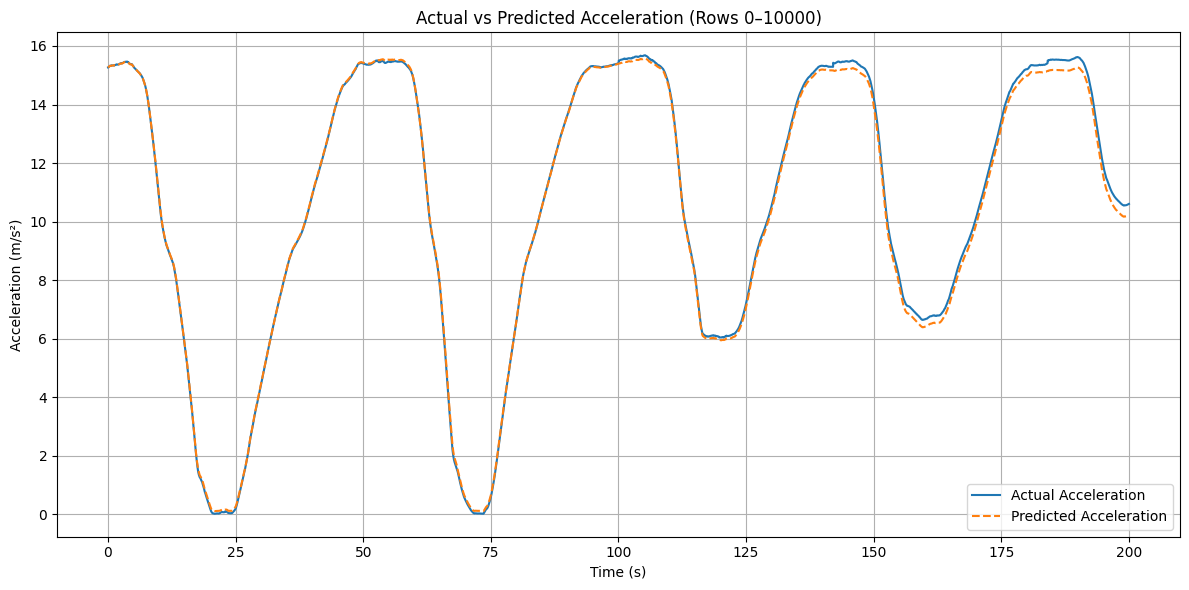

In [75]:
plot_acc_comparison_from_dataframe(long_gap, actual_col="v_follower", pred_col="pred_speed_follower", dt_col="dt", limit=(0, 10000))

## Predicted plot for xlong gap

In [76]:
xlong_gap = reformed_df[reformed_df.gap_XLong==True]
xlong_gap.shape

(193264, 11)

In [77]:
xlong_gap = compute_predicted_speed(xlong_gap)

/tmp/ipykernel_61453/1457290478.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[output_col] = predicted_speed


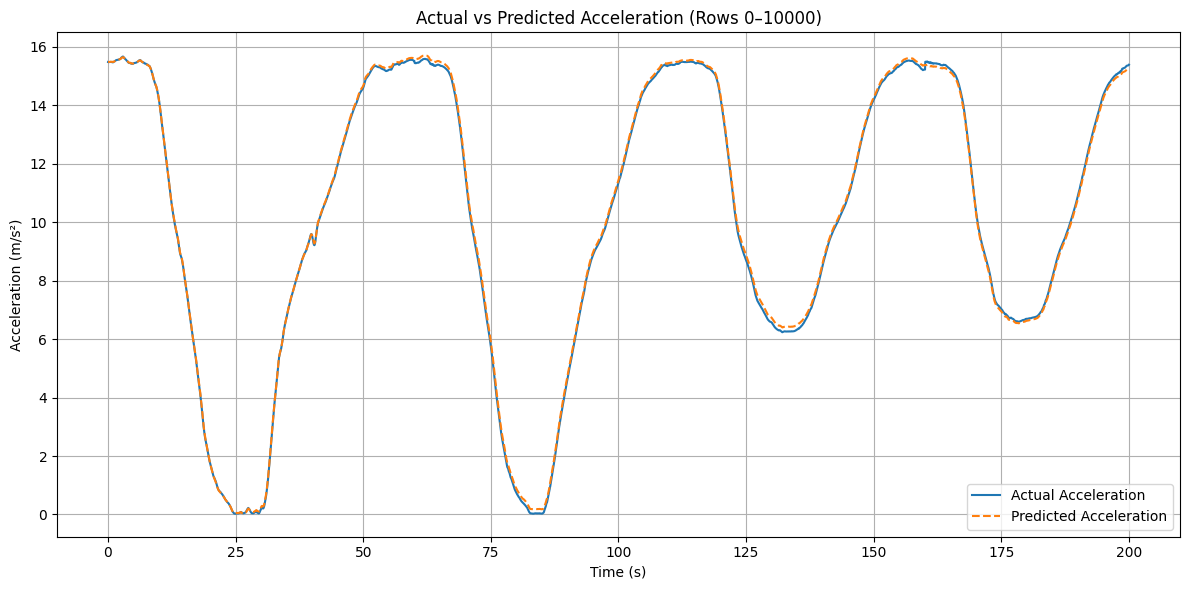

In [78]:
plot_acc_comparison_from_dataframe(xlong_gap, actual_col="v_follower", pred_col="pred_speed_follower", dt_col="dt", limit=(0, 10000))